## Homework 4

In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [113]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [114]:
df = pd.read_csv('../data/CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [115]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [116]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [117]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [118]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [119]:
df.shape

(4454, 14)

In [120]:
for col in df.columns:
    print(col, df[col].nunique())
    print(df[col].value_counts().head(3))
    print(df[col].unique()[:3])
    print('---')

seniority 47
0    535
1    510
2    454
Name: seniority, dtype: int64
[ 9 17 10]
---
home 7
owner      2107
rent        973
parents     783
Name: home, dtype: int64
['rent' 'owner' 'parents']
---
time 11
60    1932
36     942
48     860
Name: time, dtype: int64
[60 36 12]
---
age 50
28    178
26    163
32    159
Name: age, dtype: int64
[30 58 46]
---
marital 6
married      3241
single        977
separated     130
Name: marital, dtype: int64
['married' 'widow' 'single']
---
records 2
no     3681
yes     773
Name: records, dtype: int64
['no' 'yes']
---
job 5
fixed        2805
freelance    1024
partime       452
Name: job, dtype: int64
['freelance' 'fixed' 'partime']
---
expenses 94
35    1211
45     823
60     792
Name: expenses, dtype: int64
[73 48 90]
---
income 352
0      381
100    153
150    114
Name: income, dtype: int64
[129 131 200]
---
assets 159
0       1674
4000     343
5000     286
Name: assets, dtype: int64
[   0 3000 2500]
---
debt 182
0       3687
2000      59
1500      51

In [121]:
df.select_dtypes(include=['object']).columns

Index(['home', 'marital', 'records', 'job'], dtype='object')

In [122]:
df.select_dtypes(include=['int']).columns

Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price', 'default'],
      dtype='object')

- categorical features: 'home', 'marital', 'records', 'job'
- numeric features: 'seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [127]:
from sklearn.model_selection import train_test_split

In [128]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [129]:
len(df_val) / (len(df_train) + len(df_val) + len(df_test))

0.20004490345756623

In [130]:
y_train = df_train.default
y_val = df_val.default
y_test = df_test.default

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [131]:
from sklearn.metrics import roc_auc_score

In [132]:
for feature in df_train.select_dtypes(include=['int']).columns:
    if roc_auc_score(y_train, df_train[feature]) < 0.5:
        print(round(roc_auc_score(y_train, -df_train[feature]), 3), feature)
    else:
        print(round(roc_auc_score(y_train, df_train[feature]), 3), feature)

0.709 seniority
0.561 time
0.573 age
0.501 expenses
0.682 income
0.649 assets
0.505 debt
0.591 amount
0.504 price
1.0 default


senority has the highest AUC score

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [134]:
use_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [135]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[use_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[use_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [136]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [137]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [138]:
y_pred_val = model.predict(X_val)

In [139]:
round(roc_auc_score(y_val, y_pred_val), 3)

0.678

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [140]:
thresholds = np.linspace(0, 1, 101)

In [141]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [142]:
scores = []

for threshold in thresholds:
    y_pred = model.predict_proba(X_val)[:, 1]
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp + fp > 0:
        p = tp / (tp + fp)
        r = tp / (tp + fn)

        scores.append((threshold, p, r))

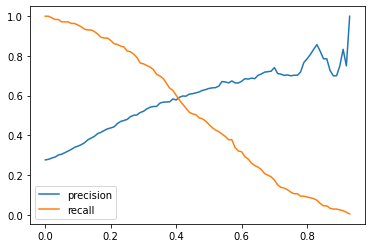

In [143]:
plt.plot([s[0] for s in scores], [s[1] for s in scores], label='precision')
plt.plot([s[0] for s in scores], [s[2] for s in scores], label='recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

the curves interest at a threshold of 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [144]:
scores = []

for threshold in thresholds:
    y_pred = model.predict_proba(X_val)[:, 1]
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp + fp > 0:
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        
        f1 = 2 * p * r / (p + r)

        scores.append((threshold, f1))

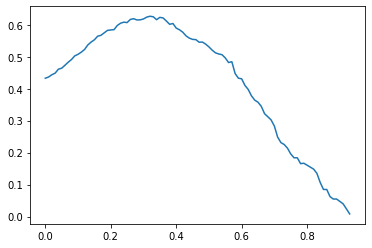

In [145]:
plt.plot([s[0] for s in scores], [s[1] for s in scores])

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

The maximum is at a F1 score of 0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [146]:
from sklearn.model_selection import KFold

In [147]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[use_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [148]:
def predict(df, dv, model):
    dicts = df[use_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [149]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.814 +- 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [150]:
def kfold_step(df_full_train, C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

In [151]:
for C in [0.01, 0.1, 1, 10]:
    print(C)
    kfold_step(df_full_train, C)

0.01
0.808 +- 0.012
0.1
0.813 +- 0.014
1
0.814 +- 0.015
10
0.814 +- 0.015


C of 0.01 has the best score

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.